# <center> LINMA2300 - Project 2: Adversarial attack against classifier</center>

#### <center>04 December 2024 - v1</center>


Prof. Geovani Grapaglia, Bastien Massion, Nicolas Mil-Homens Cavaco


# Part I: CNN Classifier

## 0. Preliminaries

#### 0.1 Imports

In [ ]:
# PyTorch is a common library for neural networks in Python. torch.nn is a module for building layers of Neural Networks.
import torch
from torch import nn
torch.set_default_dtype(torch.float64)

# Torchvision is part of the PyTorch environment. It is necessary to download the datasets from Ecifar.
from torchvision.datasets import CIFAR10
import torchvision.transforms as t
from torch.utils.data import DataLoader

# Torchinfo is an extension of PyTorch. It is really useful for understanding the structure and the size of your models.
try:
    from torchinfo import summary
except:
    print("Installing torchinfo...")
    !pip install -q torchinfo
    from torchinfo import summary
    print("torchinfo installed successfully.")

# Files management
import os

# Usual mathematical stuff
import numpy as np

# Plots
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Timing
import time
from datetime import datetime

# Compose functions with fixed arguments
from functools import partial

## Write your additional imports here

#### 0.2 Resources

#### Your own power
If you have the chance to have your own GPU (as a gamer for example), then please use it! If your have any bug with your GPU, please make us know.

The use of the CPU of your computer might be a limitation for the training process of your clasifier, but not for the inference part. So, the second part of the project should be doable on your CPU.

#### External power: Google Colab (free and advised)

To access more computing power, we advise you to use Google Colab: https://colab.research.google.com/.

Colab is a free and easy to use service from Google, where you can borrow their efficient resources. You only require one Google account, i.e. one Gmail adress, to use Colab and run code online.

The most common and easiest way of using Google Colab is to work with a Jupyter Notebook, so this one will perfectly do the job! Launch Colab, in files "import a new notebook" and select your Notebook for this homework. The Notebook is stored on the Google Drive associated the Gmail adress, while all the related files (data, generated figures, saved models) exist in folders on the computing unit that you are connected to, and are stored in the same directory as your Notebook.

As a first step with Colab, use the free option. In this setting, you often have access to nice GPU's: Nvidia T4 GPU. Be aware, GPU are sometimes not available (reserved in priority for people with paying subscriptions) and there are daily limitations to the amount of computations that you can do in one go with the free setup ("usage limits"), so don't hesitate to start this project as quickly as possible and use your computing power wisely. The whole project is doable on these T4 GPU's: it is our recommended option to make this project.

To select your resource, click on the triangle next to "Connect" in the up-right corner of your screen (see image) -> "Change runtime type" -> Select your "Hardware accelerator" -> "Save". It should then become "Connected" to the hardware you chose.

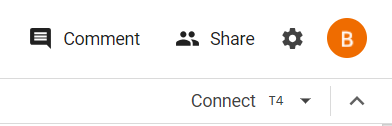
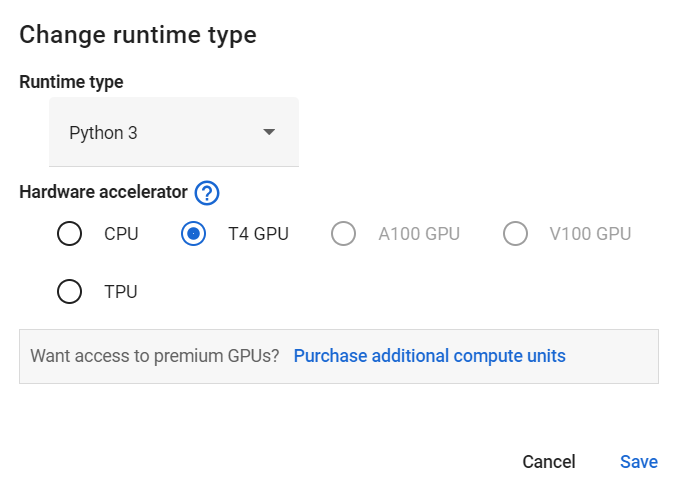

In [ ]:
##### Check if GPU is available

def chooseDevice():
    try:
        import google.colab
        machine = "colab"
        print("Working on Colab")

        from google.colab import drive
        source = "/content/drive/MyDrive/Colab Notebooks"
        drive.mount("/content/drive")
        print("Connected to Google Drive")
    except:
        machine = "own"
        source = "."
        print("Working on your own computer")

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
        if machine == "colab":
            num_workers = 2
        elif machine == "own":
            num_workers = 0
    else:
        device = torch.device("cpu")
        num_workers = 0
        print("GPU not available, CPU available")
    print("Machine:", machine)
    print("Source:", source)
    print("Device:", device)
    print("Number of workers:", num_workers)
    return machine, source, device, num_workers

If you are working Colab, you need to allow Colab to have all accesses to your Google Drive (on which files will be stored). A pop-up window will appear when running the cell below: accept everything and it will work.

In [ ]:
machine, source, device, num_workers = chooseDevice()

#### 0.3 Setup

In [ ]:
def createFolders(source):
    if not os.path.exists(source + '/Models'):
        os.makedirs(source + '/Models')
    if not os.path.exists(source + '/Figures'):
        os.makedirs(source + '/Figures')
    print("Folders created")

In [ ]:
createFolders(source)

## 1. CIFAR-10 dataset

#### 1.1 Import dataset

In [ ]:
def getData(dataset="CIFAR10", info = True):
    if dataset == "CIFAR10":
        # All images have pixels colors in the range [-1,1] for training and testing
        transform = t.Compose([t.ToTensor(), t.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        train_set = CIFAR10(root=".", train=True, download=True, transform=transform)
        classes = train_set.classes
        n_classes = len(classes)
        test_set = CIFAR10(root=".", train=False, download=True, transform=transform)
    else:
        print("DATASET NOT CORRECTLY DEFINED")
    if info:
        print(train_set)
        print(test_set)
    return train_set, test_set, classes, n_classes

In [ ]:
dataset = "CIFAR10"
train_set, test_set, classes, n_classes = getData(dataset = dataset)
n_channels = 3
height = 32
width = 32
image_size = (n_channels, height, width)

print(train_set.__dict__.keys())
print(classes)

#### 1.2 Load dataset (with DataLoader)

In [ ]:
##### Divide dataset into subsets and batches and create loaders for each subset

def divideInBatches(train_dataset, test_dataset, batch_size, num_workers):

    # Train set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    n_batches_train = len(train_loader.batch_sampler)

    # Test set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    n_batches_test = len(test_loader.batch_sampler)

    return train_loader, test_loader, n_batches_train, n_batches_test

In [ ]:
batch_size = 64

train_loader, test_loader, n_batches_train, n_batches_test = divideInBatches(train_set, test_set, batch_size, num_workers)

#### 1.3 Show samples

In [ ]:
def show_samples_image(samples, true_labels=None, predicted_labels=None, title="Samples"):
    # All images have pixels colors in the range [-1,1] for plotting
    samples = t.Normalize((-1.0,-1.0,-1.0), (2.0,2.0,2.0))(samples)

    fig, axes = plt.subplots(6, 6, figsize=(7,7))
    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.4, top=0.90)
    for i in range(6):
        for j in range(6):
            image_to_plot = torch.permute(samples[6*i+j].cpu().detach(),(1,2,0))
            if true_labels is not None:
                true_label = true_labels[6*i+j].cpu().detach().numpy()
            if predicted_labels != None:
                predicted_label = predicted_labels[6*i+j].cpu().detach().numpy()
            axes[i,j].imshow(image_to_plot)
            if true_labels is not None:
                text=classes[true_label]
            if predicted_labels != None:
                text = text+","+classes[predicted_label]
                axes[i,j].title.set_text(text)
                axes[i,j].title.set_size(8)
            axes[i,j].axis("off")
    plt.show()

In [ ]:
# Get a sample of 36 images from training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_samples_image(images, labels, None, title="Training set samples")

In [ ]:
# Get a sample of 36 images from test set
dataiter = iter(test_loader)
images, labels = next(dataiter)

show_samples_image(images, labels, None, title="Testing set samples")

## 2. Classification

#### 2.1 Model

In [ ]:
##### Define a class for Convolutional Neural Network

class CNN(nn.Module):
    def __init__(self, classes, image_size, ndf):
        self.ndf = ndf
        self.n_channels = image_size[0]
        self.height = image_size[1]
        self.width = image_size[2]
        self.classes = classes
        self.n_classes = len(self.classes)
        self.input_size = (image_size)
        self.input_type = [torch.float]
        self.output_size = (n_classes)
        self.output_type = torch.float

        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(self.n_channels, self.ndf, kernel_size = (3,3), stride = 1, padding = "same")
        self.lrelu1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(self.ndf, self.ndf, kernel_size = (3,3), stride = 1, padding = "same")
        self.lrelu2 = nn.LeakyReLU(0.2)
        self.maxpool2 = nn.MaxPool2d((2,2))
        self.drop2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(self.ndf, self.ndf*2, kernel_size = (3,3), stride = 1, padding = "same")
        self.lrelu3 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv2d(self.ndf*2, self.ndf*2, kernel_size = (3,3), stride = 1, padding = "same")
        self.lrelu4 = nn.LeakyReLU(0.2)
        self.maxpool4 = nn.MaxPool2d((2,2))
        self.drop4 = nn.Dropout2d(0.25)
        self.conv5 = nn.Conv2d(self.ndf*2, self.ndf*4, kernel_size = (3,3), stride = 1, padding = "same")
        self.lrelu5 = nn.LeakyReLU(0.2)
        self.conv6 = nn.Conv2d(self.ndf*4, self.ndf*4, kernel_size = (3,3), stride = 1, padding = "same")
        self.lrelu6 = nn.LeakyReLU(0.2)
        self.maxpool6 = nn.MaxPool2d((2,2))
        self.drop6 = nn.Dropout2d(0.25)
        self.lin7 = nn.Linear((self.ndf*4)*(self.height//8)*(self.width//8), self.n_classes)
        self.lrelu7 = nn.LeakyReLU(0.2)
        self.drop7 = nn.Dropout(0.25)
        self.lin8 = nn.Linear(self.n_classes, self.n_classes)

    def scaleToProbabilities(self, outmap, temperature = 1.0):
        #temperature = 3: everything between 0.05 and 0.17
        #temperature = 0.3: one or two values between 0.2 and 0.95
        #temperature = 0.03: one value above 0.99, rest neglectable

        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std/temperature, dim=1)
        return probabilities

    def predictLabels(self, outmap, temperature = 1.0):
        probabilities = self.scaleToProbabilities(outmap, temperature = 1.0)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty

    def forward(self, x):
        x = self.conv1(x)
        x = self.lrelu1(x)
        x = self.conv2(x)
        x = self.lrelu2(x)
        x = self.maxpool2(x)
        x = self.drop2(x)
        x = self.conv3(x)
        x = self.lrelu3(x)
        x = self.conv4(x)
        x = self.lrelu4(x)
        x = self.maxpool4(x)
        x = self.drop4(x)
        x = self.conv5(x)
        x = self.lrelu5(x)
        x = self.conv6(x)
        x = self.lrelu6(x)
        x = self.maxpool6(x)
        x = self.drop6(x)
        x = x.view(-1, (self.ndf*4)*(self.height//8)*(self.width//8))
        x = self.lin7(x)
        x = self.lrelu7(x)
        x = self.drop7(x)
        x = self.lin8(x)
        return x

In [ ]:
##### Infos about a neural network model

def getInfoModel(model, batch_size, model_name=None):
    if isinstance(model.input_size, list):
        input_size = [(batch_size, ) + in_size for in_size in model.input_size]
        dtypes = [in_type for in_type in model.input_type]
    else:
        input_size = (batch_size, ) + model.input_size
        dtypes = model.input_type
    print(input_size)
    model_summary = summary(model, input_size=input_size, dtypes=dtypes, verbose=0,
                            col_names=["input_size","output_size","num_params","kernel_size"])
    if model_name != None:
        print("Model: " + model_name)
    print(model_summary)
    return model_summary

In [ ]:
ndf = 16     # size of hidden layers
cnn = CNN(classes, image_size, ndf).to(device = device)
#cnn_info = getInfoModel(cnn, batch_size, model_name = "CNN")

#### 2.2 Loss function

In [ ]:
loss_function = nn.CrossEntropyLoss()
# PyTorch cross-entropy loss incorporates the final softmax layer.

#### 2.3 Utils

In [ ]:
##### Compute Loss and Accuracy

def computeLossAndAccuracy(cnn, loss_function, real_samples, cifar_labels, device, batch_size):
    output_cnn = cnn(real_samples)
    loss_cnn = loss_function(output_cnn, cifar_labels)
    predicted_labels, output_scaled, certainty = cnn.predictLabels(output_cnn)
    acc_train, correct_predictions = computeCNNAccuracy(predicted_labels, cifar_labels)
    return loss_cnn, acc_train

def computeCNNAccuracy(y_predicted, y_true):
    where_correct = (y_predicted == y_true)
    accuracy = where_correct.sum().item() / float(where_correct.size(0))
    return accuracy, where_correct

##### Print Loss and Accuracy

def printCNNLoss(loss_cnn, loss_test_cnn, epoch):
    print("Epoch %d: Mean Loss CNN: %.3f" %(epoch, np.mean(loss_cnn[epoch])))
    print("Epoch %d: Mean Loss CNN (test): %.3f" %(epoch, np.mean(loss_test_cnn[epoch])))

def printCNNAccuracy(accuracy_train, accuracy_test, epoch):
    print("Epoch %d: Mean Training Accuracy: %.3f" %(epoch, np.mean(accuracy_train[epoch])))
    print("Epoch %d: Mean Testing Accuracy: %.3f" %(epoch, np.mean(accuracy_test[epoch])))

##### Timing method

def computeAndPrintTime(title, epoch, start_time, end_time):
    delta_time = end_time - start_time
    hours = delta_time // 3600
    minutes = (delta_time - hours*3600) // 60
    seconds = delta_time - hours*3600 - minutes*60
    print(title, "%d: %d h %d min %.1f sec" %(epoch, hours, minutes, seconds))
    return delta_time

#### 2.4 Performances at initizalization

In [ ]:
##### Initial values of loss and accuracy

epoch = 0

loss_cnn_init = np.zeros((1, n_batches_train))
loss_test_cnn_init = np.zeros((1, n_batches_test))
accuracy_train_init = np.zeros((1, n_batches_train))
accuracy_test_init = np.zeros((1, n_batches_test))

print("Computing errors epoch", epoch)

for batch, (real_samples, cifar_labels) in enumerate(train_loader):
    real_samples = real_samples.to(device)
    cifar_labels = cifar_labels.to(device)
    #print(batch)
    loss_cnn_init[0,batch], accuracy_train_init[0,batch] = computeLossAndAccuracy(cnn, loss_function, real_samples, cifar_labels, device, batch_size)

for batch, (real_samples, cifar_labels) in enumerate(test_loader):
    real_samples = real_samples.to(device)
    cifar_labels = cifar_labels.to(device)
    #print(batch)
    loss_test_cnn_init[0,batch], accuracy_test_init[0,batch] = computeLossAndAccuracy(cnn, loss_function, real_samples, cifar_labels, device, batch_size)

printCNNLoss(loss_cnn_init, loss_test_cnn_init, epoch)
printCNNAccuracy(accuracy_train_init, accuracy_test_init, epoch)

#### 2.5 Optimizer

In [ ]:
def chooseOptimizer(name, lr_sgd_momentum=0.001, momentum_sgd=0.9, lr_adam=0.001, lr_adagrad=0.001, lr_rmsprop=0.001):
    if name == "sgdm": #SGD with momentum
        lr_sgd_momentum = lr_sgd_momentum
        momentum_sgd = momentum_sgd
        optimizer_cnn = torch.optim.SGD(cnn.parameters(), lr=lr_sgd_momentum, momentum=0.9)
    elif name == "adam": #Adam
        lr_adam = lr_adam
        optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr_adam)
    elif name == "adagrad": #Adagrad
        lr_adagrad = lr_adagrad
        optimizer_cnn = torch.optim.Adagrad(cnn.parameters(), lr=lr_adagrad)
    elif name == "rmsprop": #RMSProp
        lr_adagrad = lr_adagrad
        optimizer_cnn = torch.optim.RMSprop(cnn.parameters(), lr=lr_rmsprop)
    return optimizer_cnn

In [ ]:
# Choose your optimizer and hyperparameters values
# name_optimizer = "sgdm"
name_optimizer = "adam"
# name_optimizer = "adagrad"
# name_optimizer = "rmsprop"

optimizer_cnn = chooseOptimizer(name_optimizer)

#### 2.6 Training

In [ ]:
def train(model,
    loss_cnn_init,
    loss_test_cnn_init,
    accuracy_train_init,
    accuracy_test_init,
    device,
    loss,
    num_epoch,
    optimizer,
    n_batches_train,
    n_batches_test,
    verbose = False
    ):

    printCNNLoss(loss_cnn_init, loss_test_cnn_init, epoch = 0)
    printCNNAccuracy(accuracy_train_init, accuracy_test_init, epoch = 0)

    loss_cnn = np.zeros((num_epochs+1, n_batches_train))
    loss_test_cnn = np.zeros((num_epochs+1, n_batches_test))
    accuracy_train = np.zeros((num_epochs+1, n_batches_train))
    accuracy_test = np.zeros((num_epochs+1, n_batches_test))

    loss_cnn[0,:] = loss_cnn_init[0,:]
    loss_test_cnn[0,:] = loss_test_cnn_init[0,:]
    accuracy_train[0,:] = accuracy_train_init[0,:]
    accuracy_test[0,:] = accuracy_test_init[0,:]

    time_start = time.time()
    print("Training starts")

    for epoch in range(1,num_epochs+1):

        time_start_epoch = time.time()

        model.train()
        for batch, (real_samples, cifar_labels) in enumerate(train_loader):
            real_samples = real_samples.to(device)
            cifar_labels = cifar_labels.to(device)

            pred = model(real_samples)
            loss = loss_function(pred, cifar_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_cnn[epoch,batch], accuracy_train[epoch, batch] = computeLossAndAccuracy(model, loss_function, real_samples, cifar_labels, device, batch_size)

            if batch == 0:
                predicted_labels, _, _ = model.predictLabels(pred)
                if verbose:
                  show_samples_image(real_samples, cifar_labels, predicted_labels = predicted_labels, title="Epoch %d" %epoch)

        time_end_epoch = time.time()
        time_epoch = computeAndPrintTime("Time epoch", epoch, time_start_epoch, time_end_epoch)

        print("Computing errors epoch", epoch)

        model.eval()

        # Compute accuracy on test set
        for batch, (real_samples, cifar_labels) in enumerate(test_loader):
            real_samples = real_samples.to(device)
            cifar_labels = cifar_labels.to(device)

            loss_test_cnn[epoch,batch], accuracy_test[epoch, batch] = computeLossAndAccuracy(model, loss_function, real_samples, cifar_labels, device, batch_size)

        # Show loss and accuracy
        printCNNLoss(loss_cnn, loss_test_cnn, epoch)
        printCNNAccuracy(accuracy_train, accuracy_test, epoch)

    return loss_cnn, loss_test_cnn, accuracy_train, accuracy_test



## Basic training loop

In [ ]:
num_epochs = 30

In [ ]:
losses = train(
    model = cnn,
    loss_cnn_init=loss_cnn_init ,
    loss_test_cnn_init= loss_test_cnn_init,
    accuracy_train_init =accuracy_train_init,
    accuracy_test_init = accuracy_test_init,

    device = device,
    loss = loss_function,
    num_epoch = num_epochs,
    optimizer = optimizer_cnn,
    n_batches_train = n_batches_train,
    n_batches_test = n_batches_test,
    verbose = True
)

## Hyperparameters tuning (Grid Search)

In [ ]:
num_epochs = 10
max_tested_params = 11

In [ ]:
global_loss_cnn = np.empty((max_tested_params,num_epochs+1, n_batches_train))
global_loss_test_cnn = np.empty((max_tested_params,num_epochs+1, n_batches_test))
global_accuracy_train = np.empty((max_tested_params,num_epochs+1, n_batches_train))
global_accuracy_test = np.empty((max_tested_params,num_epochs+1, n_batches_test))

best_cnn = cnn
best_lambda = 1e-1
best_loss = np.mean(loss_test_cnn_init[-1,:])
Lambdas = np.geomspace(1e-1,1e-6,max_tested_params)

for i_param in range(max_tested_params):
    cnn = CNN(classes, image_size, ndf).to(device = device)
    optimizer_cnn = chooseOptimizer("adam",lr_adam=Lambdas[i_param])

    epoch = 0

    loss_cnn_init = np.zeros((1, n_batches_train))
    loss_test_cnn_init = np.zeros((1, n_batches_test))
    accuracy_train_init = np.zeros((1, n_batches_train))
    accuracy_test_init = np.zeros((1, n_batches_test))

    print("Computing errors epoch", epoch)

    for batch, (real_samples, cifar_labels) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        cifar_labels = cifar_labels.to(device)
        #print(batch)
        loss_cnn_init[0,batch], accuracy_train_init[0,batch] = computeLossAndAccuracy(cnn, loss_function, real_samples, cifar_labels, device, batch_size)

    for batch, (real_samples, cifar_labels) in enumerate(test_loader):
        real_samples = real_samples.to(device)
        cifar_labels = cifar_labels.to(device)
        #print(batch)
        loss_test_cnn_init[0,batch], accuracy_test_init[0,batch] = computeLossAndAccuracy(cnn, loss_function, real_samples, cifar_labels, device, batch_size)


    loss_cnn, loss_test_cnn, accuracy_train, accuracy_test = train(
        model = cnn,
        loss_cnn_init=loss_cnn_init ,
        loss_test_cnn_init= loss_test_cnn_init,
        accuracy_train_init =accuracy_train_init,
        accuracy_test_init = accuracy_test_init,
        device = device,
        loss = loss_function,
        num_epoch = num_epochs,
        optimizer = optimizer_cnn,
        n_batches_train = n_batches_train,
        n_batches_test = n_batches_test,
    )


    global_loss_cnn[i_param,:,:] = loss_cnn
    global_loss_test_cnn[i_param,:,:] = loss_test_cnn
    global_accuracy_train[i_param,:,:] = accuracy_train
    global_accuracy_test[i_param,:,:] = accuracy_test

    mean_loss_train = np.mean(loss_cnn[-1,:])
    mean_loss_test = np.mean(loss_test_cnn[-1,:])
    mean_accuracy_train = np.mean(accuracy_train[-1,:])
    mean_accuracy_test = np.mean(accuracy_test[-1,:])

    if mean_loss_train < best_loss:
        best_loss = mean_loss_train
        best_lambda = Lambdas[i_param]
        best_cnn = cnn

cnn = best_cnn

mean_test_loss = np.mean(global_loss_test_cnn[:,-1,:], axis=1)
mean_train_loss = np.mean(global_loss_cnn[:,-1,:], axis=1)
mean_test_accuracy = np.mean(global_accuracy_test[:,-1,:], axis=1)
mean_train_accuracy = np.mean(global_accuracy_train[:,-1,:], axis=1)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5), dpi = 300)

for i_param, lr in enumerate(Lambdas):
    if i_param <= 1:
      continue

    axs[0].plot(np.mean(global_loss_cnn[i_param], axis=1), label=f"lr = {lr:.2e}")
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("loss")
    axs[0].set_yscale("log")
    axs[0].set_title("Training Loss")
    axs[0].grid(True, linestyle = "--", alpha = 0.5, which = "both")
    axs[0].legend()

    axs[1].plot(np.mean(global_loss_test_cnn[i_param], axis=1), label=f"lr = {lr:.2e}")
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("loss")
    axs[1].set_yscale("log")
    axs[1].set_title("Testing Loss")
    axs[1].grid(True, linestyle = "--", alpha = 0.5, which = "both")
    axs[1].legend()

plt.show()

#### 2.7 Saving models

In [ ]:
def saveModel(model, model_name, source='.'):
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    torch.save(model.state_dict(), source + '/Models/' + model_name + '__' + now)

In [ ]:
saveModel(cnn, 'Classifier_'+name_optimizer, source=source)

#### 2.8 Learning curves

In [ ]:
def plotLoss(loss_cnn, loss_test_cnn, source="."):
    num_epochs, n_batches_train = np.shape(loss_cnn)
    _, n_batches_test = np.shape(loss_test_cnn)
    num_epochs -= 1
    epochs = np.arange(num_epochs+1)
    epochs_train_detailed = np.arange(0,num_epochs+1,1/n_batches_train)
    epochs_test_detailed = np.arange(0,num_epochs+1,1/n_batches_test)
    loss_cnn_stats = (np.mean(loss_cnn, axis = 1), np.std(loss_cnn, axis = 1))
    loss_test_cnn_stats = (np.mean(loss_test_cnn, axis = 1), np.std(loss_test_cnn, axis = 1))

    plt.close("Loss")
    plt.figure("Loss", figsize = (20,15))
    plt.title("Loss during training", fontsize=30)
    plt.grid()
    p_train, = plt.plot(epochs, loss_cnn_stats[0], label = "Train")
    col_train = p_train.get_color()
    #plt.fill_between(epochs, loss_cnn_stats[0]-loss_cnn_stats[1], loss_cnn_stats[0]+loss_cnn_stats[1], color=col_train, alpha = 0.3)
    plt.plot(epochs_train_detailed, np.ravel(loss_cnn), color=col_train, alpha = 0.3)
    p_test, = plt.plot(epochs, loss_test_cnn_stats[0], label = "Test")
    col_test = p_test.get_color()
    #plt.fill_between(epochs, loss_test_cnn_stats[0]-loss_test_cnn_stats[1], loss_test_cnn_stats[0]+loss_test_cnn_stats[1], color=col_test, alpha = 0.3)
    plt.plot(epochs_test_detailed, np.ravel(loss_test_cnn), color=col_test, alpha = 0.3)
    plt.legend(fontsize=30)
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Loss", fontsize=30)
    plt.ylim(bottom=0.0)
    plt.tick_params(axis = 'both', which = 'both',labelsize = 30)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    plt.savefig(source + '/Figures/Loss__' + now + '__' + str(num_epochs) + '_epochs.png')
    plt.show()
    return loss_cnn_stats, loss_test_cnn_stats

def plotAccuracy(accuracy_train, accuracy_test, num_epochs, source="."):
    num_epochs, n_batches_train = np.shape(accuracy_train)
    _, n_batches_test = np.shape(accuracy_test)
    num_epochs -= 1
    epochs = np.arange(num_epochs+1)
    epochs_train_detailed = np.arange(0,num_epochs+1,1/n_batches_train)
    epochs_test_detailed = np.arange(0,num_epochs+1,1/n_batches_test)
    accuracy_train_stats = (np.mean(accuracy_train, axis = 1), np.std(accuracy_train, axis = 1))
    accuracy_test_stats = (np.mean(accuracy_test, axis = 1), np.std(accuracy_test, axis = 1))

    plt.close("Accuracy")
    plt.figure("Accuracy", figsize = (20,15))
    plt.title("Accuracy of classifier", fontsize=30)
    plt.grid()
    epochs = np.arange(num_epochs+1)
    p_train, = plt.plot(epochs, accuracy_train_stats[0], label = "Train", linestyle='-')
    col_train = p_train.get_color()
    #plt.fill_between(epochs, accuracy_train_stats[0]-accuracy_train_stats[1], accuracy_train_stats[0]+accuracy_train_stats[1], alpha = 0.3)
    plt.plot(epochs_train_detailed, np.ravel(accuracy_train), color=col_train, alpha = 0.3)
    p_test, = plt.plot(epochs, accuracy_test_stats[0], label = "Test", linestyle='-')
    col_test = p_test.get_color()
    #plt.fill_between(epochs, accuracy_test_stats[0]-accuracy_test_stats[1], accuracy_test_stats[0]+accuracy_test_stats[1], alpha = 0.3)
    plt.plot(epochs_test_detailed, np.ravel(accuracy_test), color=col_test, alpha = 0.3)
    plt.legend(fontsize=30)
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Accuracy", fontsize=30)
    plt.ylim(0.0,1.0)
    plt.axhline(y=0.1, color='darkgray', linestyle='--', label='Random classifier')
    plt.tick_params(axis = 'both', which = 'both',labelsize = 30)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    plt.savefig(source + '/Figures/Accuracy__' + now + '__' + str(num_epochs) + '_epochs.png')
    plt.show()
    return accuracy_train_stats, accuracy_test_stats

In [ ]:
loss_cnn_stats, loss_test_cnn_stats = plotLoss(loss_cnn, loss_test_cnn, source=source)
accuracy_train_stats, accuracy_test_stats = plotAccuracy(accuracy_train, accuracy_test, num_epochs, source=source)

#### 2.9 Loading models

In [ ]:
def loadModel(model, model_name, date_time, device="cpu", source='.'):
    model.load_state_dict(torch.load(source + '/Models/' + model_name + '__' + date_time, map_location=device, weights_only=True))
    model.eval()
    model.requires_grad_(False)
    return model

In [ ]:
cnn_loaded = CNN(classes, image_size, ndf).to(device = device)
saving_datetime = None
saving_datetime = '2024_12_11__09_45_21' #example of saving_datetime
loadModel(cnn_loaded, 'Classifier_'+name_optimizer, saving_datetime, device=device, source=source)
#cnn_info = getInfoModel(cnn_loaded, batch_size, model_name = "CNN")

# Part 2: Adversarial Attack

## 4. Derivative Free Optimization methods

#### 4.1 Random Finite Differences (RFD)

In [ ]:
# Random finite difference
def rfd(f : callable, x0 : np.ndarray, MAX_ITER : int = 50, alpha : float =1e-4, mu : float =1e-4, tol : float =1e-5):

    x_k = x0.copy()
    fvals = [f(x_k)]

    for _ in range(MAX_ITER):
        u = np.random.randn(x0.shape[0])
        g = (f(x_k + mu*u) - fvals[-1])/mu * u
        x_k -= alpha*g
        fvals.append(f(x_k))
        if np.linalg.norm(g) < tol:
            break


    return x_k, fvals

#### 4.2 Stochastic Three Points (STP)

In [ ]:
# Stochastic Three Points
def stp(f, x0, MAX_ITER=100, alpha=1e-4):

    x_k = x0.copy()
    fvals = [f(x_k)]

    for _ in range(MAX_ITER):
        s = 1/np.sqrt(x0.shape[0]) * np.random.randn(x0.shape[0])
        x_candidate = [x_k + alpha*s, x_k - alpha*s, x_k]

        f_candidate = [f(x_candidate[0]),f(x_candidate[1]),fvals[-1]]
        choice = np.argmin(f_candidate)
        x_k = x_candidate[choice]
        fvals.append(f_candidate[choice])

    return x_k, fvals

#### 4.3 Derivative-Free Trust-Region (DFTR)

In [ ]:
# Derivative Free Trust-Region
def dftr(f, x0, B_0=None, MAX_ITER=1000, eta=0.1, L=10, Delta_0=0.1, eps=1e-1):
    B_k = np.eye(x0.shape[0]) if B_0 is None else B_0
    x_k = x0.copy()
    Delta_k = Delta_0
    fvals = [f(x_k)]

    g_k = finite_difference_grad(f, x_k, fvals[0], eps, L, Delta_k)

    for _ in range(MAX_ITER):

        d_k = cauchy_step(g_k, B_k, Delta_k)
        m_k = fvals[-1] + np.dot(d_k, g_k) + 0.5 * np.dot(np.dot(B_k, d_k), d_k)
        rho_k = (fvals[-1] - f(x_k + d_k))/(fvals[-1] - m_k)

        if rho_k >= eta :
            x_k += d_k
            Delta_k *= 2
            fvals.append(f(x_k))
        else :
            Delta_k /= 2
            fvals.append(fvals[-1])

        g_kp1 = finite_difference_grad(f, x_k, fvals[-1], eps, L, Delta_k)
        B_k = bfgs(B_k, d_k if rho_k >= eta else np.zeros_like(d_k), g_kp1, g_k)
        g_k = g_kp1

    return x_k, fvals, B_k

def cauchy_step(g, B, Delta):
    norm_g = np.linalg.norm(g)
    t = np.min([Delta/norm_g, norm_g**2/(g.T@B@g)])
    d_c = -t*g
    return d_c

def bfgs(B_k, s_k, g_kp1, g_k):
    y_k = g_kp1-g_k
    sy= s_k@y_k
    if sy > 0:
        Bs = B_k @ s_k
        B_kp1 = B_k + np.outer(y_k,y_k)/sy - np.outer(Bs, Bs)/(s_k@Bs)
        return B_kp1
    else:
        return B_k

def finite_difference_grad(f, x, fx, eps, L, Delta):
    n = len(x)
    h = np.min([eps/(L*np.sqrt(n)), Delta/np.sqrt(n)])
    g = np.zeros(n)
    for i in range(n):
        x_h = np.copy(x)
        x_h[i] += h
        g[i] = (f(x_h) - fx)/h
    return g

#### 4.4 Derivative-Free Trust-Region with Random Subspace Technique (DFTR-RST)

In [ ]:
def dftr_rst(f, x0, p=500, Q=None, B_0=None, MAX_ITER=1000, eta=0.1, L=10, Delta_0=0.1, eps=1e-3):

    Q = 1/np.sqrt(p) * np.random.randn(x0.shape[0], p) if Q is None else Q.copy()
    f_hat = lambda z : f(x0 + np.dot(Q, z))
    z_0 = np.zeros(p)

    z_k, fvals_dftr_proj, B_k = dftr(f_hat, z_0, B_0=B_0, MAX_ITER=MAX_ITER, eta=eta, L=L, Delta_0=Delta_0, eps=eps)
    x_dftr_proj = x0 + np.dot(Q, z_k)

    return x_dftr_proj, fvals_dftr_proj, B_k

## 5. Adversarial attacks

#### 5.1 Objective function

In [ ]:
# Define the loss function
def loss(noise_flat, img_flat, target, classifier):
    score = probas(img_flat+noise_flat, classifier)
    return -np.log(score[target])

def probas(img_flat, classifier):
    n_channels = classifier.n_channels
    height = classifier.height
    width = classifier.width
    reshaped_img = torch.from_numpy(img_flat).reshape(n_channels, width, height)
    scores = classifier(reshaped_img)
    probas = classifier.scaleToProbabilities(scores, temperature=1.0).detach().cpu().numpy()[0]
    return probas

#### 5.2 Show attacks

In [ ]:
def normalize(img, M = None):
    img = img - img.min()
    M = img.max() if M is None else M
    return img / M

def show_img(img, title=None):
    img_bis = np.zeros((width, height, n_channels))
    img = img.reshape((n_channels, width, height))
    for i in range(n_channels):
        img_bis[:,:,i] = img[i,:,:]
    plt.figure(figsize=(3,3))
    plt.imshow(normalize(img_bis))
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_output(img_flat, soln_x, f, classifier, init_pred):
    classes = classifier.classes

    loss_final = f(soln_x)
    pred_prob = probas(soln_x+img_flat, classifier)
    final_pred = np.argmax(pred_prob)
    print("final loss:", loss_final)
    print('new predicted probabilities:', pred_prob)
    print('new predicted class: %s' %classes[final_pred])

    n_channels = classifier.n_channels
    height = classifier.height
    width = classifier.width

    soln_x_bis = np.zeros((width, height, n_channels))
    soln_x = soln_x.reshape(n_channels, width, height)
    img_bis = np.zeros((width, height, n_channels))
    img = img_flat.reshape((n_channels, width, height))

    for i in range(n_channels):
        soln_x_bis[:,:,i] = soln_x[i,:,:]
        img_bis[:,:,i] = img[i,:,:]

    # Visualize images
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(8)
    im = ax[0].imshow(normalize(img_bis))
    ax[0].set_title("Initial image (%s)" % classes[init_pred])
    ax[0].axis('off')
    #plt.colorbar(im)

    im = ax[1].imshow(normalize(img_bis+soln_x_bis))
    ax[1].set_title("Corrupted image (%s)" % classes[final_pred])
    ax[1].axis('off')
    #plt.colorbar(im)

    im = ax[2].imshow(normalize(soln_x_bis))
    ax[2].set_title("Noise")
    ax[2].axis('off')
    #plt.colorbar(im)
    plt.show()

def show_noise(soln_x, img_flat, step, p_rst, f, classifier, title=None):
    classes = classifier.classes
    n_channels = classifier.n_channels
    height = classifier.height
    width = classifier.width

    img_bis = np.zeros((width, height, n_channels))
    img = img_flat.reshape((n_channels, width, height))

    for i in range(n_channels):
        img_bis[:,:,i] = img[i,:,:]

    N = soln_x.shape[1]
    M = 0
    I = 0
    for _ in range(0,N,step): I+=1
    for k in range(I):
        img_temp = soln_x[:,k*step].reshape(n_channels, width, height)
        m = img_temp.max() - img_temp.min()
        if m > M : M = m
    fig,ax = plt.subplots(int(np.ceil(I/3)),3)
    fig2,ax2 = plt.subplots(int(np.ceil(I/3)),3)
    fig.set_figwidth(8)
    fig2.set_figwidth(8)
    for k in range(I):
        pred_prob = probas(soln_x[:,k*step]+img_flat, classifier)
        final_pred = np.argmax(pred_prob)
        soln_x_bis = np.zeros((width, height, n_channels))
        soln_x_temp = soln_x[:,k*step].reshape(n_channels, width, height)

        for i in range(n_channels):
            soln_x_bis[:,:,i] = soln_x_temp[i,:,:]

        im = ax[k//3,k%3].imshow(normalize(img_bis+soln_x_bis))
        im = ax2[k//3,k%3].imshow(normalize(soln_x_bis,M))
        if k == 0:
            ax[k//3,k%3].set_title("Initial image (%s)" % classes[final_pred], fontsize=8)
            ax2[k//3,k%3].set_title("Initial noise", fontsize=8)
        else:
            ax[k//3,k%3].set_title(f"{k*step} iterations ({classes[final_pred]})", fontsize=8)
            ax2[k//3,k%3].set_title(f"{k*step} iterations", fontsize=8)
        ax[k//3,k%3].axis('off')
        ax2[k//3,k%3].axis('off')

    for j in range(k+1,k+3-k%3):
        im = ax[k//3,j%3].imshow(normalize(np.zeros((width, height, n_channels))))
        im = ax2[k//3,j%3].imshow(normalize(np.zeros((width, height, n_channels))))
        ax[k//3,j%3].axis('off')
        ax2[k//3,j%3].axis('off')

    fig.suptitle("Evolution of the visual quality of the image")
    fig2.suptitle("Evolution of the added noise")
    plt.show(fig)
    plt.show(fig2)
    fig.savefig("Figures/"+title+"_ImQE.pdf")
    fig2.savefig("Figures/"+title+"_NE.pdf")

def show_noise_ampl(Noise_level, Noise_level_2, p_rst, n = 3072,title=None):
    plt.figure()
    plt.title("Amplitude of the noise for unconstrained DFO")
    plt.plot(np.arange(Noise_level_2.shape[0]),Noise_level_2, label=f"DFTR")
    plt.plot(np.arange(Noise_level.shape[0]),Noise_level, label=f"DFTR-RST with p={p_rst}")
    plt.xlabel("Number of iterations")
    plt.ylabel(r"$\|d\|_2$")
    plt.legend()
    plt.grid(True)
    plt.savefig("Figures/"+title+".pdf")
    plt.show()

#### 5.3 Attack initialization

In [ ]:
# Select batch
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Define image to attack
img = images[4].detach().cpu().numpy().flatten()

# Define the starting point and target
init_score = probas(img, cnn_loaded)
init_pred = np.argmax(init_score)
index = list(set(range(n_classes)) - {init_pred})
target = np.random.choice(index)

# Define objective function
f = partial(loss, img_flat=img, target=target, classifier=cnn_loaded)

# Define initial guess
init_noise = np.zeros_like(img)

# Print initial classification + target + init loss function value
print("init predicted scores:", init_score, "\ninit prediction:", classes[init_pred], "\ntarget:", classes[target])
print("initial loss:", f(init_noise))
show_img(img, title=classes[init_pred])

#### 5.4 Attack examples

#### RFD

In [ ]:
x_rfd, fvals_rfd = rfd(f, init_noise, alpha=2e-5, mu=1e-5, MAX_ITER=40000, tol=-1)

In [ ]:
show_output(img, x_rfd, f, cnn_loaded, init_pred)

#### STP

In [ ]:
x_stp, fvals_stp = stp(f, init_noise, MAX_ITER=20000, alpha=1e-3)

In [ ]:
show_output(img, x_stp, f, cnn_loaded, init_pred)

#### DFTR

In [ ]:
x_dftr, fvals_dftr, _ = dftr(f, init_noise, MAX_ITER=15, B_0=np.eye(img.size), eta=0.1, L=10, Delta_0=0.1, eps=1e-3)

In [ ]:
show_output(img, x_dftr, f, cnn_loaded, init_pred)

#### DFTR-RST

In [ ]:
p_rst=200
x_dftr_rst, fvals_dftr_rst, _ = dftr_rst(f, init_noise, p=p_rst, Q=None, B_0=None, MAX_ITER=50, eta=0.1, L=10, Delta_0=0.1, eps=1e-3)

In [ ]:
show_output(img, x_dftr_rst, f, cnn_loaded, init_pred)

#### 5.5 Learning curves

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Learning curves for unconstrained DFO")
plt.plot(fvals_rfd, label="RFD")
plt.plot(fvals_stp, label="STP")
plt.plot(fvals_dftr, label="DFTR")
plt.plot(fvals_dftr_rst, label=f"DFTR-RST with p={p_rst}")
plt.xscale("log")
plt.xlabel("Number of iterations", fontsize=14)
plt.yscale("log")
plt.ylabel(r"$\tilde F(d_k)$", fontsize=14)
plt.legend() #loc="upper right")
plt.grid(True, which="both", ls="--")
plt.savefig("Figures/LC_DFO_ite.pdf")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Learning curves for unconstrained DFO")
plt.plot(np.arange(len(fvals_rfd)),fvals_rfd, label="RFD")
plt.plot(np.arange(len(fvals_stp))*2,fvals_stp, label="STP")
plt.plot(np.arange(len(fvals_dftr))*(init_noise.shape[0]+1),fvals_dftr, label="DFTR")
plt.plot(np.arange(len(fvals_dftr_rst))*(p_rst+1),fvals_dftr_rst, label=f"DFTR-RST with p={p_rst}")
plt.xscale("log")
plt.xlabel("Number of function evaluations", fontsize=14)
plt.yscale("log")
plt.ylabel(r"$\tilde F(d_k)$", fontsize=14)
plt.legend() #loc="upper right")
plt.grid(True, which="both", ls="--")
plt.savefig("Figures/LC_DFO_fe.pdf")
plt.show()

#### 5.6 Recommendation

TO COMPLETE

#### 5.7 Study the quality of the image with respect to the number of iterations on 3 images.

In [ ]:
classes = cnn_loaded.classes
for i in range(64):
    img = images[i].detach().cpu().numpy().flatten()
    init_score = probas(img, cnn_loaded)
    init_pred = np.argmax(init_score)
    print(classes[init_pred], i)
    show_img(img)

In [ ]:
def visu_comp(img,cnn_loaded,p_rst,init_noise,f,N_iterations=25,N_iterations_2=15):
    curr_x = init_noise
    curr_B = np.eye(p_rst)
    Q = 1/np.sqrt(p_rst) * np.random.randn(curr_x.shape[0], p_rst)
    Noise_level = np.zeros(N_iterations+1)
    Noise = np.zeros((init_noise.shape[0],N_iterations+1))
    for i in range(1,N_iterations+1):
        curr_x, _, curr_B = dftr_rst(f, curr_x, p=p_rst, Q=Q, B_0=curr_B, MAX_ITER=1, eta=0.1, L=10, Delta_0=0.1, eps=1e-3)
        Noise_level[i] = np.linalg.norm(curr_x)
        Noise[:,i] = curr_x

    curr_x = init_noise
    curr_B = np.eye(init_noise.shape[0])
    Noise_level_2 = np.zeros(N_iterations_2+1)
    Noise_2 = np.zeros((init_noise.shape[0],N_iterations_2+1))
    for i in range(1,N_iterations_2+1):
        curr_x, _, curr_B = dftr(f, curr_x, B_0=curr_B, MAX_ITER=1, eta=0.1, L=10, Delta_0=0.1, eps=1e-3)
        Noise_level_2[i] = np.linalg.norm(curr_x)
        Noise_2[:,i] = curr_x

    return Noise, Noise_level, Noise_2, Noise_level_2

img_indices = [4,9,13]


for i in img_indices:
    img = images[i].detach().cpu().numpy().flatten()
    init_score = probas(img, cnn_loaded)
    init_pred = np.argmax(init_score)
    index = list(set(range(n_classes)) - {init_pred})
    target = np.random.choice(index)
    f = partial(loss, img_flat=img, target=target, classifier=cnn_loaded)

    Noise, Noise_level, Noise_2, Noise_level_2 = visu_comp(img,cnn_loaded,p_rst,init_noise,f)
    show_noise_ampl(Noise_level, Noise_level_2,p_rst,title=f"Noise_amp_fig{i}")
    show_noise(Noise, img, 5, p_rst, f, cnn_loaded,title=f"Noise_dftr_rst_fig{i}")
    show_noise(Noise_2, img, 3, init_noise.shape[0], f, cnn_loaded,title=f"Noise_dftr_fig{i}")

END